# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data.csv` disponibilizado no e-class. O arquivo contém as variáveis `week` e `volume`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.

**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

# Trabalho A1 — Séries Temporais
---
### Integrantes
- Guilherme Carvalho
- Guilherme Buss
- Gustavo Bianchi
- João Gabriel
- Luís Felipe Marciano
- Vinícius Nascimento

### Objetivos
- Carregar e analisar data.csv
- Implementar baselines (mean, naive, seasonal naive, drift)
- Testar transformações (Box-Cox / log)
- Decompor série em tendência e sazonalidade
- Criar covariáveis (tempo, dummies sazonais, sen/cos, lags, rollings)
- Ajustar modelos de regressão linear múltipla
- Diagnosticar resíduos (ACF, Ljung-Box)
- Comparar usando métricas: MAE, RMSE, MAPE, MASE

---

## **Importação das bibliotecas**

In [130]:
# básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from datetime import datetime

# para modelos 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# para decomposição e testes
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

---

## **Pré-visualização dos dados**

In [131]:
df = pd.read_csv("data.csv")

df['week'] = pd.to_datetime(df['week']) # converter week para datetime
df = df.sort_values('week').reset_index(drop=True) # ordenar por data e reset index
df = df.set_index('week')

# checar informações
print(df.info())
print('Tamanho da série:', len(df))
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2022-10-31 to 2025-09-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  150 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
None
Tamanho da série: 150
            volume
week              
2022-10-31    0.33
2022-11-07    0.47
2022-11-14    0.32
2022-11-21    1.69
2022-11-28    1.23


---

## **Análise inicial dos dados de `volume`**

Antes de iniciar a modelagem, realizamos uma análise descritiva da variável `volume` para compreender sua forma e dispersão de suas amostras.

#### **Centralidade**

* *Média:* O valor médio de `volume` ao longo de todo o período. 
* *Mediana:* O valor que divide a série em duas metades, mais robusta a outliers.

#### **Dispersão**

* *Desvio Padrão:* Grau de dispersão médio dos dados em relação à média.
* *Variância:* É o quadrado do desvio padrão. 

#### **Forma da Distribuição**

* *Assimetria (Skewness):* Mede a falta de simetria da distribuição.
    * `~ 0`: Distribuição aproximadamente simétrica.
    * `> 0`: Assimetria positiva (à direita). A cauda direita da distribuição é mais longa, e a média tende a ser maior que a mediana.
    * `< 0`: Assimetria negativa (à esquerda). A cauda esquerda é mais longa, e a média tende a ser menor que a mediana.

#### **Valores Extremos**

* *Mínimo e Máximo:* Os menores e maiores valores de `volume` observados na série. Ajudam a entender a amplitude total dos dados.

In [132]:
# Métricas iniciais
mean = np.mean(df["volume"])
median = np.median(df["volume"])

std = np.std(df["volume"])
variance = np.var(df["volume"])

skewness = stats.skew(df["volume"])

max_df = np.max(df["volume"])
min_df = np.min(df["volume"])
range_df = max_df - min_df

In [133]:
print("- VARIÁVEL VOLUME - " * 5)
print("-" * 100)

print("--- Tendência Central ---")
print(f"{'Média:':<25} {mean:,.2f}")
print(f"{'Mediana:':<25} {median:,.2f}")

print("\n--- Dispersão ---")
print(f"{'Desvio Padrão:':<25} {std:,.2f}")
print(f"{'Variância:':<25} {variance:,.2f}")

print("\n--- Forma da Distribuição ---")
print(f"{'Assimetria (Skewness):':<25} {skewness:.4f}")

print("\n--- Valores Extremos ---")
print(f"{'Valor Mínimo:':<25} {min_df:,.2f}")
print(f"{'Valor Máximo:':<25} {max_df:,.2f}")
print(f"{'Amplitude (Range):':<25} {range_df:,.2f}")

print("-" * 100)

- VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - 
----------------------------------------------------------------------------------------------------
--- Tendência Central ---
Média:                    4.12
Mediana:                  3.00

--- Dispersão ---
Desvio Padrão:            4.04
Variância:                16.32

--- Forma da Distribuição ---
Assimetria (Skewness):    1.0339

--- Valores Extremos ---
Valor Mínimo:             0.14
Valor Máximo:             16.59
Amplitude (Range):        16.45
----------------------------------------------------------------------------------------------------


A análise nos mostra que a série de volume não é 'bem comportada'. Ela tem uma forte assimetria positiva e alta volatilidade. Futuramente, veremos através do gráfico que o grande causador disso seria reflexo da presença de picos em valores elevados. Essa observação que fizemos sugere a possível necessidade de uma transformação de variável (como a logarítmica) antes da modelagem, o que pode estabilizar a variância e tornar a distribuição mais simétrica, o que tende a melhorar o ajuste e o poder preditivo de modelos de regressão.

---

## **Análise de *Estacionariedade* da série temporal**

A estacionariedade é uma premissa fundamental para muitos modelos de séries temporais. Uma série é dita estacionária se suas propriedades estatísticas, como média e variância, são constantes ao longo do tempo. Nesta seção, investigamos se a série de `volume` atende a essa premissa através de análise visual e Função de Autocorrelação (ACF).

### **Inspeção Visual**

Verificaremos através de visualizações se a série é ou não estacionária:

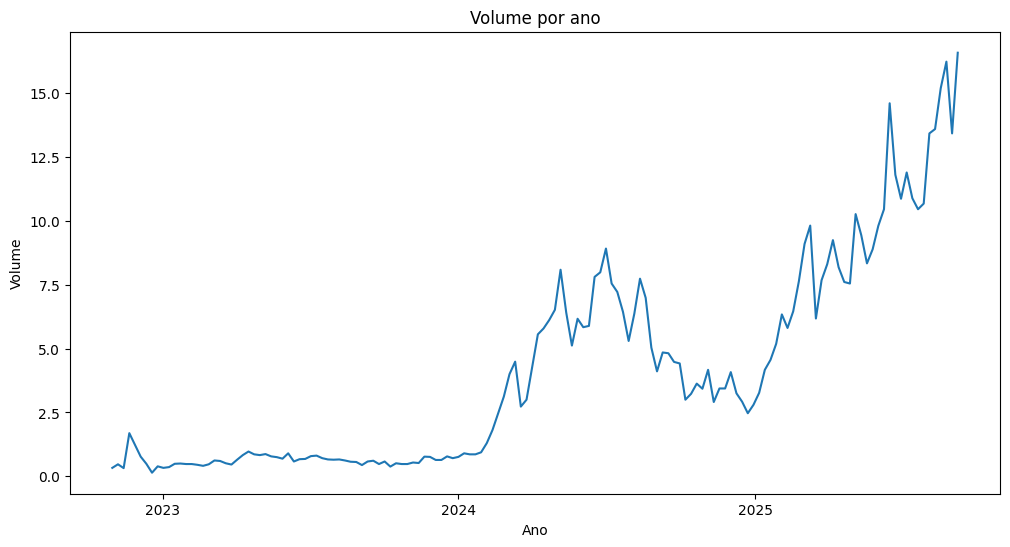

In [134]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['volume'])

# mostrar apenas os anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Volume")
plt.title("Volume por ano")
plt.show()

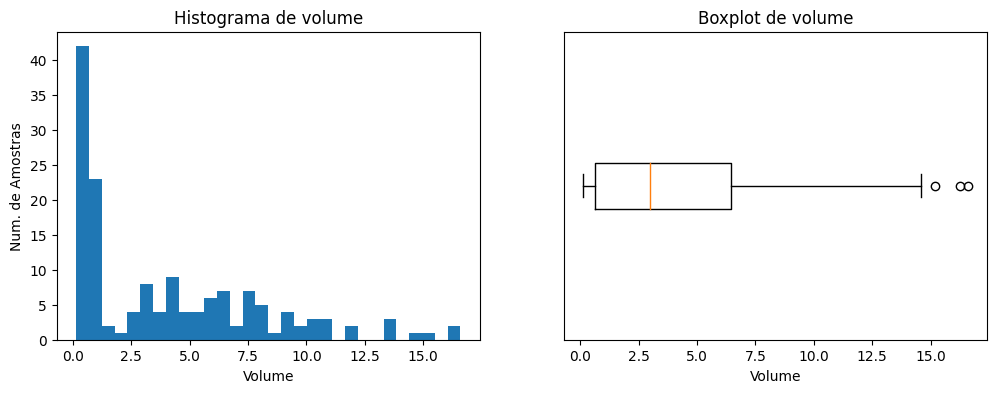

In [135]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['volume'].dropna(), bins=30)
plt.title('Histograma de volume')
plt.xlabel("Volume")
plt.ylabel("Num. de Amostras")

plt.subplot(1,2,2)
plt.boxplot(df['volume'].dropna(), vert=False)
plt.title('Boxplot de volume')
plt.yticks([])
plt.xlabel("Volume")
plt.show()

Os gráficos sugerem fortemente que a série é não-estacionária, já que:
1.  *Há tendência de crescimento:* Temos uma tendência de alta no `volume` ao longo do período analisado, indicando que a média da série não é constante.
2.  *Variância inconstante:* As oscilações do `volume` aumentam conforme o nível da série sobe, com vales e picos mais distantes.

### **Análise da Série Diferenciada**

Dado que a análise inicial indicou que a série `volume` não é estacionária — possivelmente devido a uma tendência ou variações na média ao longo do tempo —, aplicamos a técnica de diferenciação. Este processo visa estabilizar a média da série, tornando-a estacionária.

O objetivo agora é avaliar se a diferenciação foi bem-sucedida. Para isso, realizaremos novamente a inspeção visual e a análise da Função de Autocorrelação (ACF) na série transformada. Esperamos observar que a série diferenciada não exiba mais tendências claras e que sua autocorrelação decaia rapidamente para zero.

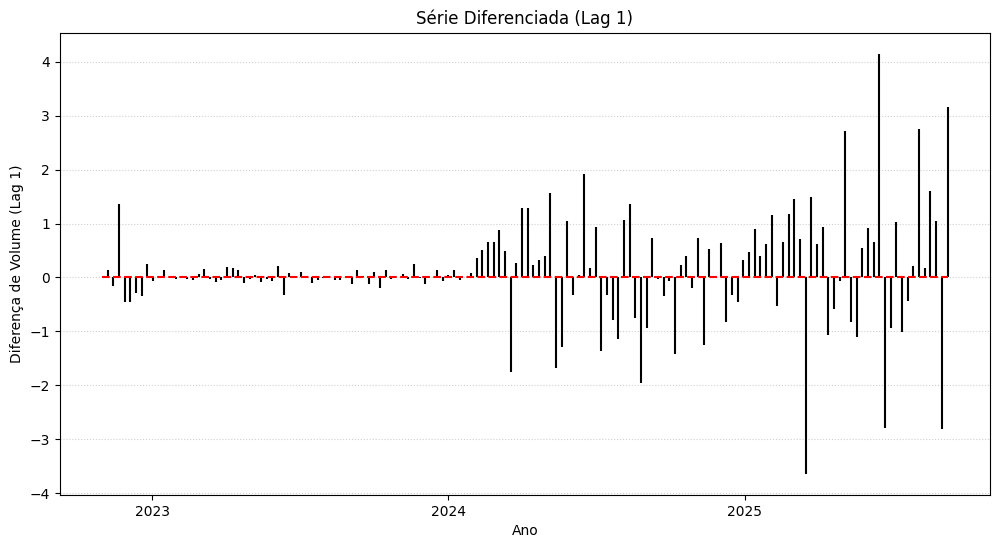

In [136]:
# Diferenciação (Lag 1)
df['volume_diff'] = np.where(df['volume'].diff(1) != np.nan, df['volume'].diff(1), 0)

plt.figure(figsize=(12, 6))

(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

A série diferenciada (Lag 1) mostra que os valores ainda apresentam flutuações grandes ao longo do tempo, com oscilações que parecem se intensificar nos períodos mais recentes. Apesar da diferenciação, não há uma estabilização em torno da linha zero, o que indica que a série ainda pode carregar estruturas de dependência temporal não removidas apenas pela primeira diferenciação.

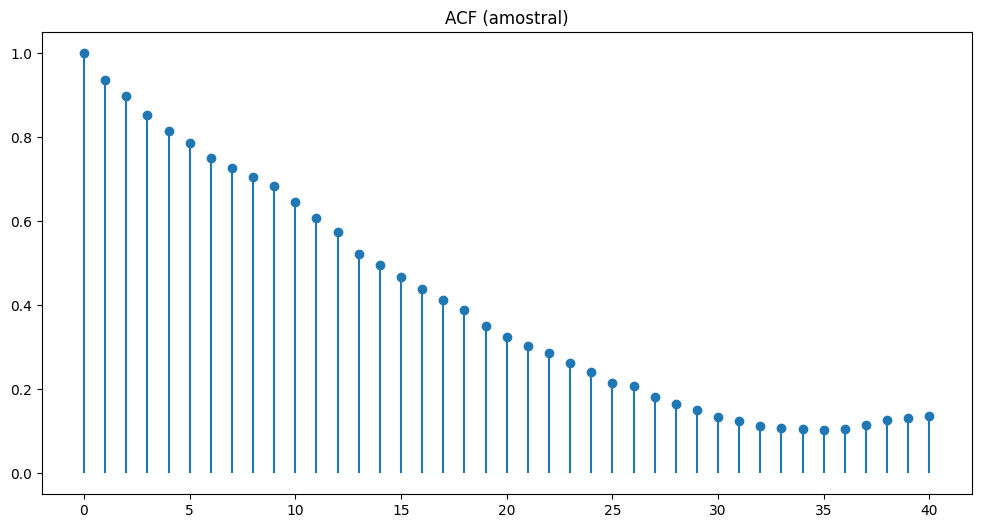

In [137]:
lag_acf = acf(df['volume'].dropna(), nlags=40, fft=False)
plt.figure(figsize=(12,6))
plt.stem(range(len(lag_acf)), lag_acf, basefmt=' ')
plt.title('ACF (amostral)')
plt.show()

Reforçando essa interpretação, o gráfico da ACF exibe uma decadência lenta e gradual das autocorrelações ao longo das defasagens, o que é característica de séries com forte dependência e possível não estacionariedade.

Dessa forma, pode ser necessária a aplicação de mais diferenciações ou transformações adicionais para garantir a estacionariedade antes da modelagem (por exemplo, em ARIMA).

### **Usando Log-Transformação: Será?**

O logaritmo estabiliza a variância, fazendo com que a série se comporte de forma mais homogênea e facilitando a modelagem, especialmente em séries com tendência de crescimento exponencial. Como nossa série tem crescimento aparentemente exponencial, podemos fazer um teste de resíduo após a mudança e observar se vale a pena utilizar uma log-transformação.

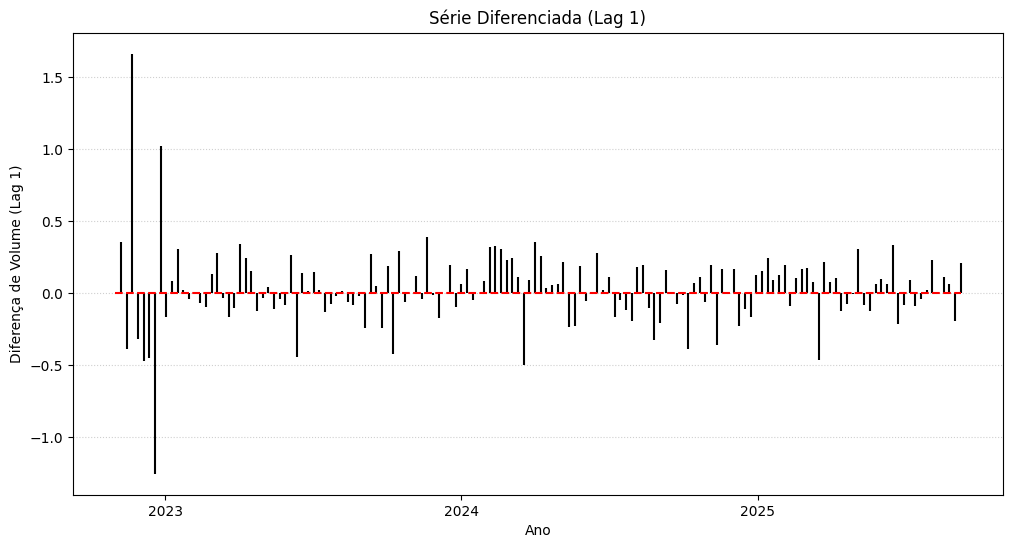

In [138]:
df['volume_log'] = np.log(df['volume']) 
df['volume_log_diff'] = np.where(df['volume_log'].diff(1) != np.nan, df['volume_log'].diff(1), 0)

#print(df.head())
plt.figure(figsize=(12, 6))
(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_log_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

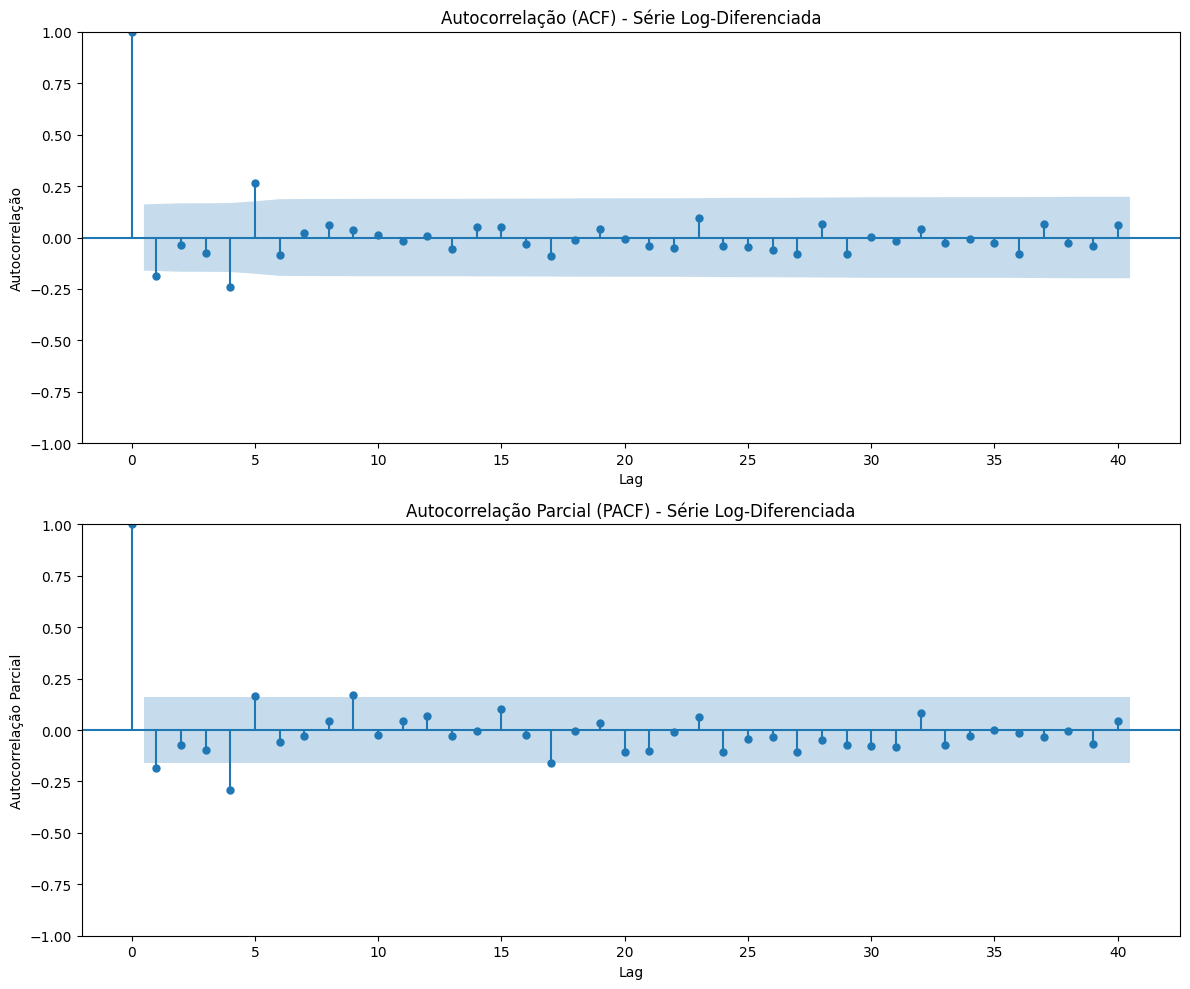

In [139]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF
sm.graphics.tsa.plot_acf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax1)
ax1.set_title('Autocorrelação (ACF) - Série Log-Diferenciada')
ax1.set_ylabel("Autocorrelação")
ax1.set_xlabel("Lag")

# PACF
sm.graphics.tsa.plot_pacf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF) - Série Log-Diferenciada')
ax2.set_ylabel("Autocorrelação Parcial")
ax2.set_xlabel("Lag")

plt.tight_layout()
plt.show()

As flutuações da série transformada tornaram-se visivelmente mais regulares. Analisando seus gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF), observamos que a maioria dos lags cai rapidamente dentro do intervalo de confiança. Isso sugere que a transformação foi eficaz em remover a maior parte da estrutura de dependência temporal, tornando a série adequada para modelagem. Adotaremos a transformação logarítmica como um passo padrão antes de ajustar nossos modelos de regressão.

---

## **Decomposição em Tendência, Sazonalidade e Resíduos**

Para entender melhor os padrões da série `volume`, realizamos uma decomposição para separar seus três principais componentes:

1.  **Tendência:** O comportamento de longo prazo da série.
2.  **Sazonalidade:** Padrões que se repetem em intervalos fixos.
3.  **Resíduos:** A parte "restante" da série após a remoção da tendência e da sazonalidade.

Utilizamos o método STL (Seasonal-Trend decomposition using LOESS), que é robusto e flexível. Assumimos um período sazonal de 52 semanas, correspondente a um ciclo anual.

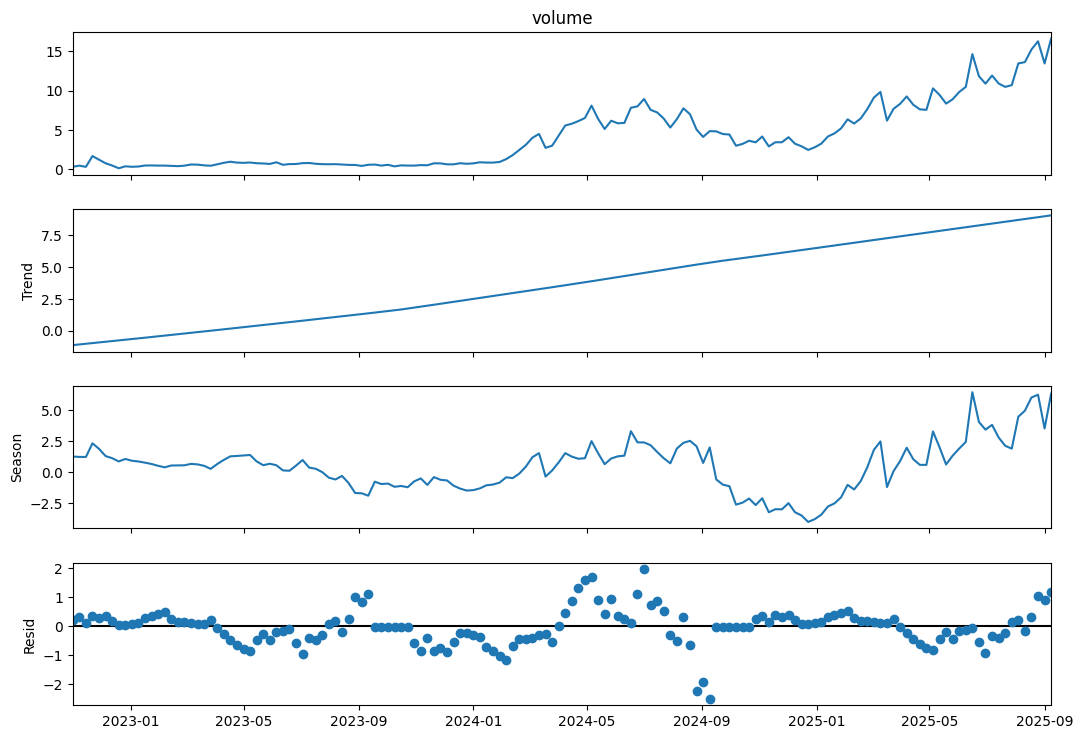

In [140]:
# como os dados são semanais, um período sazonal comum é 52 (semanas em um ano)
# vamos usar STL (Seasonal-Trend decomposition using LOESS) que é robusto a outliers
stl = STL(df['volume'], period=52)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.show()

# Extraindo os componentes
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['resid'] = res.resid

A análise do gráfico de decomposição revela:
-   **Tendência:** Confirma a tendência de crescimento que observamos visualmente, mostrando um aumento consistente no nível do volume ao longo do tempo.
-   **Sazonalidade:** Existe um padrão sazonal claro, com picos e vales ocorrendo em épocas semelhantes a cada ano. Este componente será fundamental para a criação de variáveis nos modelos de regressão.
-   **Resíduos:** Os resíduos parecem ser aleatórios em torno de zero, embora com uma variância que também parece aumentar com o tempo, reforçando a decisão de usar a transformação logarítmica.

A presença de tendência e sazonalidade justifica porque devemos incluir elas explicitamente em nossos modelos de regressão para capturar a dinâmica da série.

---

## **Métricas de Avaliação e Estratégia de Validação**

Para avaliar e comparar o desempenho dos modelos, utilizaremos as seguintes métricas:

-   **Mean Absolute Error (MAE):** Mede a média dos erros absolutos. É fácil de interpretar, pois está na mesma unidade da variável de resposta.
-   **Root Mean Squared Error (RMSE):** Similar ao MAE, mas penaliza erros maiores com mais intensidade. Também está na unidade da variável original.
-   **Mean Absolute Percentage Error (MAPE):** Expressa o erro como uma porcentagem, útil para comparar a precisão entre séries de diferentes escalas.

Para uma avaliação justa, dividimos nossa série cronologicamente:
-   **Conjunto de Treino:** Dados do início até as últimas 52 semanas.
-   **Conjunto de Teste:** As últimas 52 semanas (aproximadamente 1 ano).

Todos os modelos serão treinados usando apenas o conjunto de treino e avaliados no conjunto de teste para simular uma previsão "out-of-sample". Como nossos modelos de regressão preverão o logaritmo do volume, as previsões serão transformadas de volta para a escala original (usando a exponencial) antes de calcular as métricas.

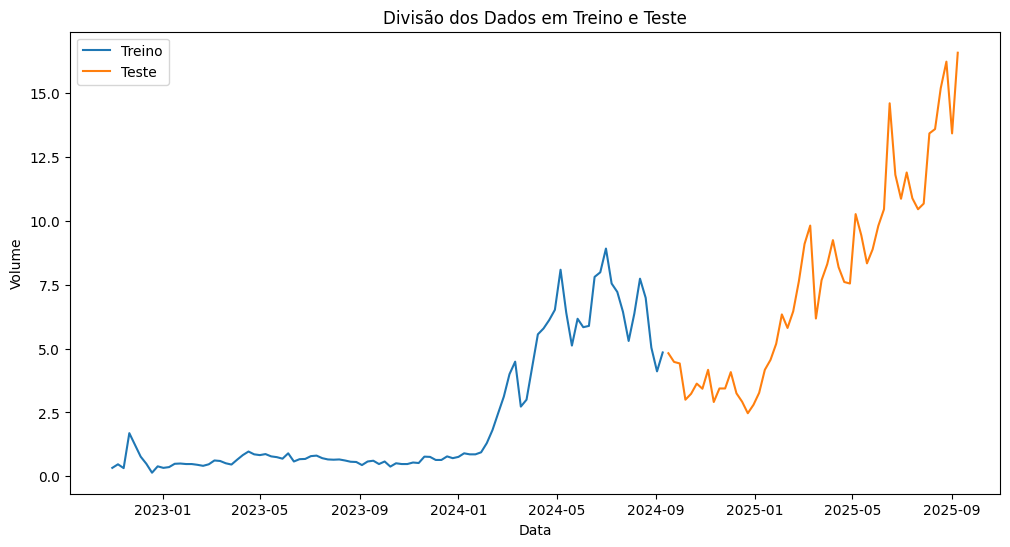

In [141]:
# tamanho do conjunto de teste (ex: últimos 12 meses, aprox. 52 semanas)
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

# transformação logarítmica
y_train = np.log(train_df['volume'])
y_test = np.log(test_df['volume'])

plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['volume'], label='Treino')
plt.plot(test_df.index, test_df['volume'], label='Teste')
plt.title('Divisão dos Dados em Treino e Teste')
plt.ylabel('Volume')
plt.xlabel('Data')
plt.legend()
plt.show()

---
## **Modelos Baseline**

Antes de construir modelos complexos, estabelecemos baselines para termos um ponto de referência de desempenho. Um modelo sofisticado só é útil se superar significativamente um modelo simples. Implementamos:

1.  **Modelo da Média:** Prevê que todos os valores futuros serão a média histórica do conjunto de treino.
2.  **Modelo Naive:** Prevê que o próximo valor será igual ao último valor observado no treino.
3.  **Modelo Seasonal Naive:** Prevê que o valor em um determinado período será igual ao valor observado no mesmo período do ciclo anterior (ex: o volume desta semana será igual ao da mesma semana do ano passado).

--- Resultados dos Modelos Baseline ---
                     MAE      RMSE      MAPE
Mean            6.497604  7.593935  0.790644
Naive           3.762692  4.856629  0.444018
Seasonal Naive  4.082692  4.621097  0.595786


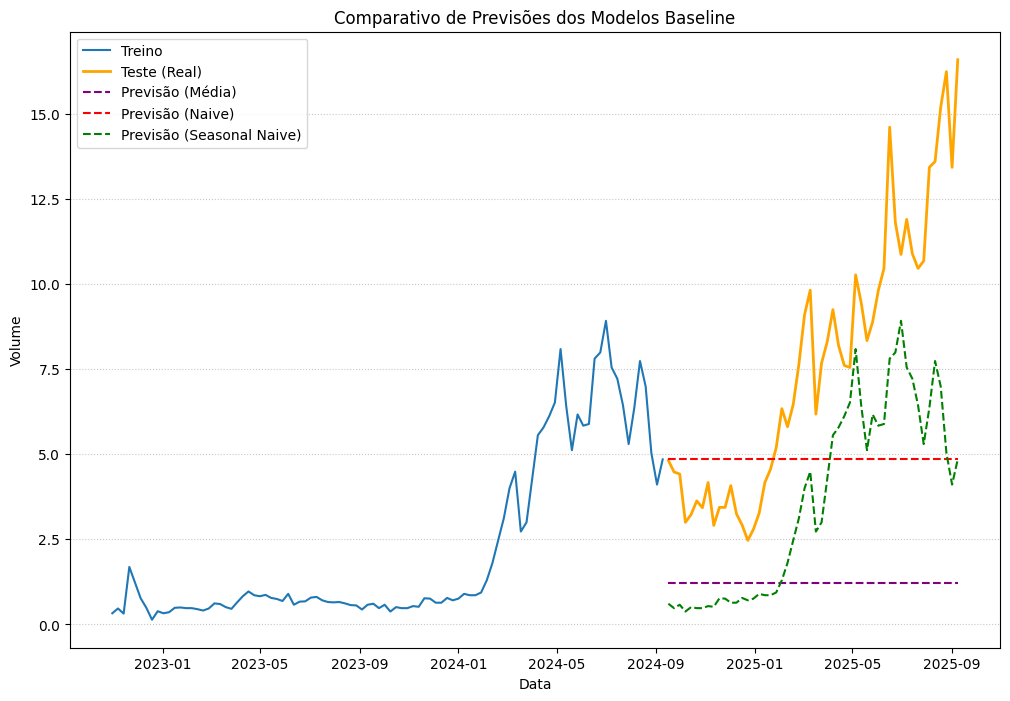

In [142]:
results = {}

# 1. Média
pred_mean = np.full(len(y_test), y_train.mean())

# 2. Naive (último valor observado)
pred_naive = np.full(len(y_test), y_train.iloc[-1])

# 3. Seasonal Naive (último valor do mesmo período sazonal)
pred_seasonal_naive = y_train.iloc[-52:].values

# revertendo a transformação logarítmica para calcular as métricas
pred_mean_orig = np.exp(pred_mean)
pred_naive_orig = np.exp(pred_naive)
pred_seasonal_naive_orig = np.exp(pred_seasonal_naive)
y_test_orig = np.exp(y_test)

# métricas
results['Mean'] = {
    'MAE': mean_absolute_error(y_test_orig, pred_mean_orig),
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, pred_mean_orig)),
    'MAPE': mean_absolute_percentage_error(y_test_orig, pred_mean_orig)
}
results['Naive'] = {
    'MAE': mean_absolute_error(y_test_orig, pred_naive_orig),
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, pred_naive_orig)),
    'MAPE': mean_absolute_percentage_error(y_test_orig, pred_naive_orig)
}
results['Seasonal Naive'] = {
    'MAE': mean_absolute_error(y_test_orig, pred_seasonal_naive_orig),
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, pred_seasonal_naive_orig)),
    'MAPE': mean_absolute_percentage_error(y_test_orig, pred_seasonal_naive_orig)
}

results_df = pd.DataFrame(results).T
print("--- Resultados dos Modelos Baseline ---")
print(results_df)

plt.figure(figsize=(12, 8))

# dados reais
plt.plot(train_df.index, train_df['volume'], label='Treino')
plt.plot(test_df.index, test_df['volume'], label='Teste (Real)', color='orange', linewidth=2)

# previsões
plt.plot(test_df.index, pred_mean_orig, label='Previsão (Média)', linestyle='--', color='purple')
plt.plot(test_df.index, pred_naive_orig, label='Previsão (Naive)', linestyle='--', color='red')
plt.plot(test_df.index, pred_seasonal_naive_orig, label='Previsão (Seasonal Naive)', linestyle='--', color='green')

plt.title('Comparativo de Previsões dos Modelos Baseline')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

**Resultados dos Baselines:**

| Modelo | MAE | RMSE | MAPE
| :--- | :--- | :--- | :--- |
| Mean | 6.497604 | 7.593935 | 0.790644 |
| Naive | 3.762692 | 4.856629 | 0.444018 |
| Seasonal Naive | 4.082692 | 4.621097 | 0.595786 |

O modelo **Seasonal Naive** apresentou o melhor desempenho na métrica RMSE (4.62), que penaliza erros maiores com mais intensidade. No entanto, o modelo **Naive** foi superior tanto em MAE (3.76) quanto em MAPE (0.44), indicando que, na média, suas previsões foram mais precisas.

Dado que o RMSE é sensível a grandes desvios, usaremos o **Seasonal Naive** como o principal benchmark a ser superado, pois na prática é comum querermos evitar os erros mais extremos. Ainda assim, a forte performance do modelo **Naive** demonstra que a informação mais recente (o último ponto da série) é um preditor muito poderoso.



# Preparação de Dados para Modelagem Preditiva
### Criando Recursos Temporais (Time-Based Features)

Antes de aplicar qualquer modelo, é necessário que enriqueçamos a nossa série temporal. O fato de termos apenas week e volume como features é definitivamente o principal limitador de qualquer modelo que não seja um simples baseline.

Assim, iremos adicionar informações adicionais para "aprender" a sazonalidade, a tendência e a dependência de curto prazo, como:

| Recurso | Descrição | Utilidade
| :--- | :--- | :--- |
| Sazonalidade | ```week_of_year, month, quarter``` | Captura o padrão repetitivo |
| Tendência | ```time_index``` | Uma contagem simples (ex: 1,2,3,…, N) | 
| Dependência Temporal | Lags de ```volume``` | Para ver a dependência do volume de hoje com o volume de ontem | 



In [143]:
df_prepared = df.drop(columns=["trend", "seasonal", "resid"])
#print(df_prepared[0:20])

df_prepared["week_of_year"] = df_prepared.index.isocalendar().week.astype(int)
df_prepared["month"] = df_prepared.index.month
df_prepared["quarter"] = df_prepared.index.quarter

df_prepared["time_index"] = np.arange(len(df_prepared))

# --- Feature de Lag (Dependência Temporal) ---
# lag 1
df_prepared["lag_volume_log_1"] = df_prepared["volume_log"].shift(1)

# Média do log-volume para imputação (evitar o "nan" no primeiro dia)
mean_log_volume = df_prepared['volume_log'].mean()
df_prepared['lag_volume_log_1' ] = df_prepared['lag_volume_log_1' ].fillna(mean_log_volume)

df_prepared[['volume_diff', 'volume_log_diff']] = df_prepared[['volume_diff', 'volume_log_diff']].fillna(0)
print(df_prepared.head(5))

            volume  volume_diff  volume_log  volume_log_diff  week_of_year  \
week                                                                         
2022-10-31    0.33         0.00   -1.108663         0.000000            44   
2022-11-07    0.47         0.14   -0.755023         0.353640            45   
2022-11-14    0.32        -0.15   -1.139434        -0.384412            46   
2022-11-21    1.69         1.37    0.524729         1.664163            47   
2022-11-28    1.23        -0.46    0.207014        -0.317714            48   

            month  quarter  time_index  lag_volume_log_1  
week                                                      
2022-10-31     10        4           0          0.780483  
2022-11-07     11        4           1         -1.108663  
2022-11-14     11        4           2         -0.755023  
2022-11-21     11        4           3         -1.139434  
2022-11-28     11        4           4          0.524729  


In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Definindo o target (y) e as features (X)
y = df_prepared['volume_log']
features = ['time_index', 'week_of_year', 'month', 'quarter', 'lag_volume_log_1'] 
X = df_prepared[features]

X_encoded = pd.get_dummies(X, columns=['week_of_year', 'month', 'quarter'], drop_first=True)

# Divisão (com o teste size de 52, 1 ano)
X_train = X_encoded.iloc[:-test_size]
X_test = X_encoded.iloc[-test_size:]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

# Inicializando o Modelo de Regressão Linear do sklearn
model = LinearRegression()
model.fit(X_train, y_train)

# previsòes
y_pred_log = model.predict(X_test)

# voltando a forma com exponencial para plot
y_pred_orig = np.exp(y_pred_log)
y_test_orig = np.exp(y_test)

# as Métricas (olhar se melhor que baselines)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

print(f"--- Resultados da Regressão Múltipla (MLR) ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

--- Resultados da Regressão Múltipla (MLR) ---
MAE: 1.9439
RMSE: 2.6057
MAPE: 28.32%


## Plot das Previsões

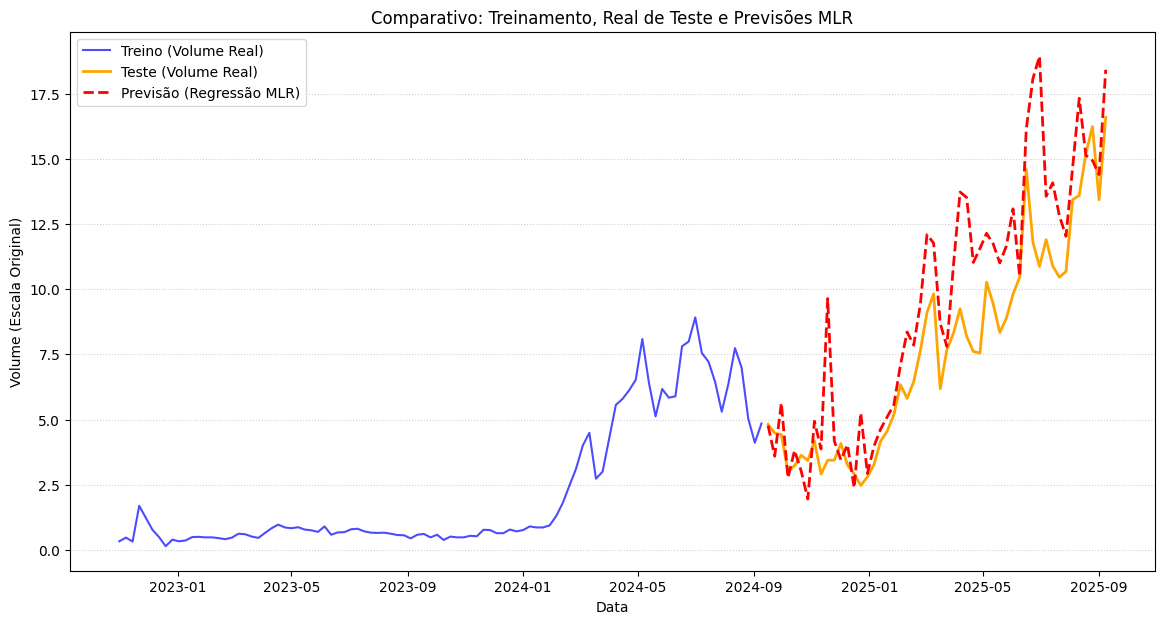

In [145]:
predictions_series = pd.Series(y_pred_orig, index=test_df.index)

plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df['volume'], label='Treino (Volume Real)', color='blue', alpha=0.7)
plt.plot(test_df.index, test_df['volume'], label='Teste (Volume Real)', color='orange', linewidth=2)

# Previsões da Regressão Múltipla
plt.plot(predictions_series.index, predictions_series.values, 
         label='Previsão (Regressão MLR)', color='red', linestyle='--', linewidth=2)

plt.title('Comparativo: Treinamento, Real de Teste e Previsões MLR')
plt.xlabel('Data')
plt.ylabel('Volume (Escala Original)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

## Análise dos Resíduos

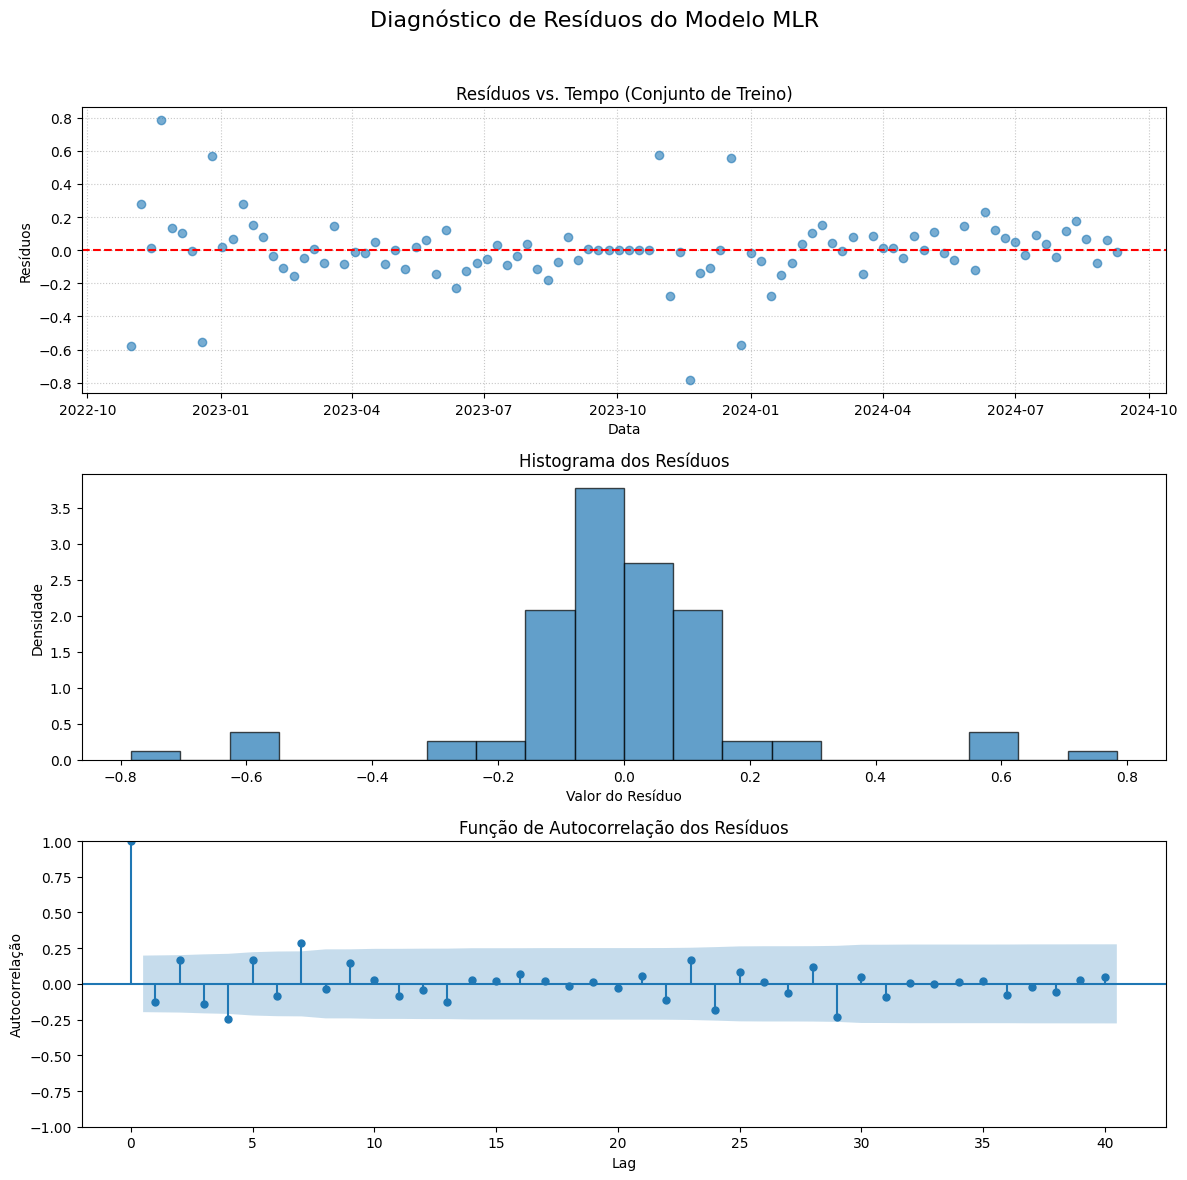


Teste de Ljung-Box para Autocorrelação dos Resíduos
      lb_stat  lb_pvalue
10  28.209752   0.001671
20  32.073134   0.042525
30  53.487141   0.005241
40  56.907663   0.040292


In [146]:
residuos = y_train - model.predict(X_train)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR', fontsize=16)

# Resíduos ao Longo do Tempo
axs[0].plot(residuos.index, residuos, marker='o', linestyle='None', alpha=0.6)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True, linestyle=':', alpha=0.7)

# Histograma dos resíduos
axs[1].hist(residuos, bins=20, density=True, edgecolor='k', alpha=0.7)
axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')

# Função de autocorrelação dos resíduos
sm.graphics.tsa.plot_acf(residuos, lags=40, ax=axs[2])
axs[2].set_title('Função de Autocorrelação dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste de Ljung-Box para autocorrelação
ljung_box_results = acorr_ljungbox(residuos, lags=[10, 20, 30, 40], return_df=True)
print("\nTeste de Ljung-Box para Autocorrelação dos Resíduos")
print(ljung_box_results)

O primeiro gráfico mostra que: **1 (ponto positivo)-** os resíduos parecem estar distribuídos em torno da linha 0, não apresentando tendência de crescimento ou decrescimento; e **2 (ponto negativo)-** a variância dos pontos não parece ser constante durante todo o período, violando o princípio da homoscedasticidade.

Já o segundo gráfico, por sua vez, nos mostra uma distribuição dos resíduos que se assemelha a de uma **normal com média 0**, algo desejado em um modelo de regressão linear.

No gráfico de ACF, a autocorrelação em todos os níveis de lag se mostrou dentro ou bem próxima do intervalo de confiança, sinal de um bom ajuste de modelo.

Por fim, e contrastando com o teste de ACF, o teste de Ljung-Box apresentou *p_value* muito pequeno, rejeitando a hipótese nula e indicando o impacto do efeito acumulado das autocorrelações na não-independência dos resíduos. 

## MLR v2

Alterações que serão feitas:

- **Introdução de Features Cíclicas**: Modelar as semanas e os meses com seno e cosseno introduz uma relação de ciclo que não existia antes. Ex.: Mês 12 era considerado distante do mês 1, apesar de estarem próximos no calendário.

- **Lags Adicionais**: Incentiva o aprendizado de dependências de curto e longo prazo.

- **Média Móvel**: Introduzimos uma média móvel do *volume_log* das 4 semanas anteriores, visando captar com mais precisão as tendências locais.

In [147]:
df_featured = df_prepared.copy()

# Features Cíclicas para sazonalidade
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month']/12.0)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month']/12.0)
df_featured['week_sin'] = np.sin(2 * np.pi * df_featured['week_of_year']/52.0)
df_featured['week_cos'] = np.cos(2 * np.pi * df_featured['week_of_year']/52.0)

# Lags Adicionais
for lag in [2, 3, 4, 52]:
    df_featured[f'lag_volume_log_{lag}'] = df_featured['volume_log'].shift(lag)

# Média Móvel para tendência de curto prazo
df_featured['rolling_mean_4'] = df_featured['volume_log'].shift(1).rolling(window=4).mean()

df_featured = df_featured.fillna(df_prepared['volume_log'].mean())

# Treinamento do Novo Modelo
features_v2 = [
    'time_index', 
    'lag_volume_log_1', 'lag_volume_log_2', 'lag_volume_log_3', 'lag_volume_log_4', 'lag_volume_log_52',
    'month_sin', 'month_cos', 
    'week_sin', 'week_cos',
    'rolling_mean_4'
]

X_v2 = df_featured[features_v2]
y_v2 = df_featured['volume_log']

X_train_v2 = X_v2.iloc[:-test_size]
X_test_v2 = X_v2.iloc[-test_size:]
y_train_v2 = y_v2.iloc[:-test_size]
y_test_v2 = y_v2.iloc[-test_size:]

model_v2 = LinearRegression()
model_v2.fit(X_train_v2, y_train_v2)

# Avaliação do Novo Modelo
y_pred_log_v2 = model_v2.predict(X_test_v2)
y_pred_orig_v2 = np.exp(y_pred_log_v2)
y_test_orig_v2 = np.exp(y_test_v2)

mae_v2 = mean_absolute_error(y_test_orig_v2, y_pred_orig_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_orig_v2, y_pred_orig_v2))
mape_v2 = np.mean(np.abs((y_test_orig_v2 - y_pred_orig_v2) / y_test_orig_v2)) * 100

print("--- Resultados do MLR v2 ---")
print(f"MAE: {mae_v2:.4f}")
print(f"RMSE: {rmse_v2:.4f}")
print(f"MAPE: {mape_v2:.2f}%")

--- Resultados do MLR v2 ---
MAE: 8.8588
RMSE: 10.9776
MAPE: 101.80%


## Plot das Previsões - MLR v2

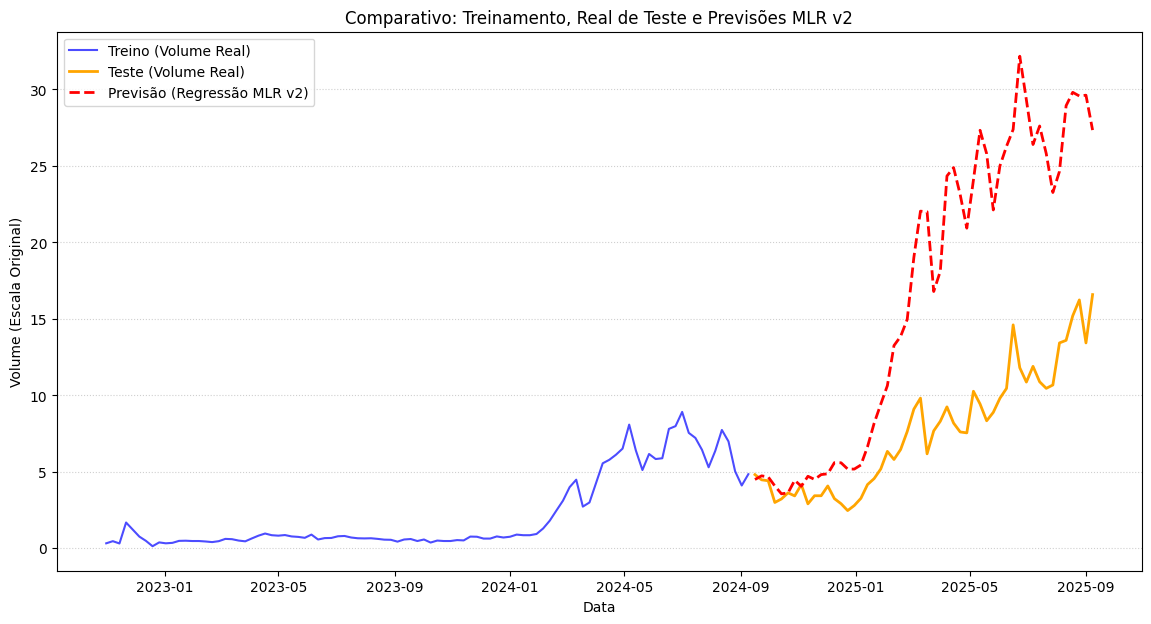

In [148]:
predictions_series = pd.Series(y_pred_orig_v2, index=test_df.index)

plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df['volume'], label='Treino (Volume Real)', color='blue', alpha=0.7)
plt.plot(test_df.index, test_df['volume'], label='Teste (Volume Real)', color='orange', linewidth=2)

# Previsões da Regressão Múltipla
plt.plot(predictions_series.index, predictions_series.values, 
         label='Previsão (Regressão MLR v2)', color='red', linestyle='--', linewidth=2)

plt.title('Comparativo: Treinamento, Real de Teste e Previsões MLR v2')
plt.xlabel('Data')
plt.ylabel('Volume (Escala Original)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

## Análise dos Resíduos

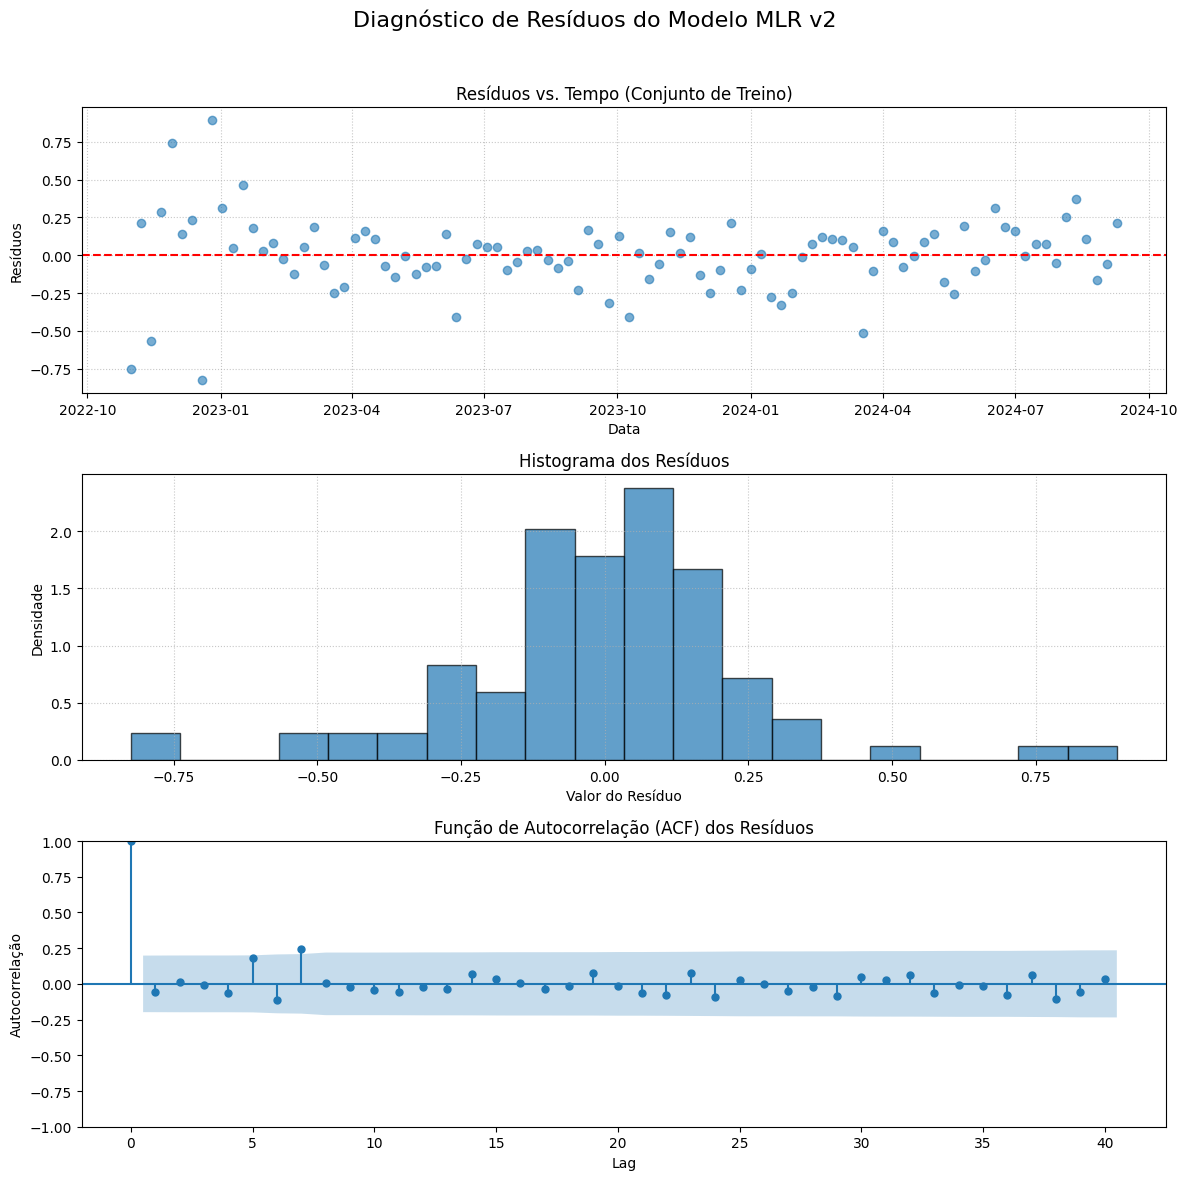


--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---
      lb_stat  lb_pvalue
10  12.260790   0.267982
20  14.495843   0.804493
30  19.421803   0.930732
40  24.990036   0.969512


In [149]:
residuos_v2 = y_train_v2 - model_v2.predict(X_train_v2)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR v2', fontsize=16)

# 1. Gráfico de Resíduos ao Longo do Tempo
axs[0].plot(residuos_v2.index, residuos_v2, marker='o', linestyle='None', alpha=0.6)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True, linestyle=':', alpha=0.7)

# 2. Histograma dos resíduos para verificar a normalidade
axs[1].hist(residuos_v2, bins=20, density=True, edgecolor='k', alpha=0.7)
axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True, linestyle=':', alpha=0.7)

# 3. Função de autocorrelação (ACF) para verificar independência
sm.graphics.tsa.plot_acf(residuos_v2, lags=40, ax=axs[2])
axs[2].set_title('Função de Autocorrelação (ACF) dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste de Ljung-Box para autocorrelação nos resíduos
ljung_box_results_v2 = acorr_ljungbox(residuos_v2, lags=[10, 20, 30, 40], return_df=True)
print("\n--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---")
print(ljung_box_results_v2)

O primeiro gráfico mostra dois pontos positivos: **1)** podemos observar que a correlação entre os resíduos foi mitigada, sem tendência aparente; e **2)** a variância parece constante ao longo do tempo (homocedasticidade).

O segundo gráfico, por sua vez, exibe uma distribuição de resíduos que se assemelha a uma **Normal com média zero**, o que é ideal.

No gráfico de ACF, a autocorrelação para quase todos os lags está dentro do intervalo de confiança, indicando que os **resíduos são independentes**, um sinal de bom ajuste.

Apesar dos diagnósticos mostrarem um modelo estatisticamente válido. Porém, os valores de **MAE**, **RMSE** e **MAPE** cresceram, um forte indicador de complexidade excessiva e/ou overfitting nessa segunda versão do modelo.

Desse modo, mais ajustes devem ser feitos a fim de encontrar um meio-termo entre as duas versões, um modelo generalizado e que seja estatisticamente válido.

## **MLR v3**

### Alterações que serão feitas no MLR v3:

* **Substituição do Modelo por Regularização L1 (Lasso)**: O modelo v2, apesar de ter corrigido a autocorrelação dos resíduos (um problema do v1), perdeu poder de previsão, um forte sinal de overfitting. Para combater isso, trocaremos a `Regressão Linear` padrão (usada no v1 e v2) pelo `Lasso`. Este modelo penaliza coeficientes grandes, o que força o modelo a ser mais simples. Sua principal vantagem é que ele pode zerar o peso de features menos importantes, realizando uma seleção automática de variáveis e diminuindo a complexidade que leva à superestimação.

* **Simplificação das Features de Tendência e Lag**: O v2 adicionou múltiplas features de lag e uma média móvel para capturar a autocorrelação que o v1 ignorava. No entanto, essa complexidade excessiva prejudicou a generalização do modelo. Para encontrar um meio-termo:
    * Vamos **remover a média móvel (`rolling_mean_4`)**, que foi introduzida no v2, por ser muito sensível a ruídos recentes e potencializar o overfitting.
    * Vamos **remover os lags intermediários** (`lag_2`, `lag_3`, `lag_4`), mantendo apenas os mais essenciais: o lag imediato (`lag_1`, já usado desde o v1) e o lag sazonal (`lag_52`).
    * Manteremos as **features cíclicas** (`sin`/`cos`), pois elas foram uma melhoria clara em relação ao `get_dummies` usado no v1 para representar a sazonalidade.

O objetivo é criar um modelo que retenha as boas ideias do v2 (tratamento adequado da sazonalidade e lags importantes), mas com a simplicidade e regularização necessárias para evitar o overfitting.

In [157]:
# 1. Features Cíclicas (mantidas)
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month']/12.0)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month']/12.0)
df_featured['week_sin'] = np.sin(2 * np.pi * df_featured['week_of_year']/52.0)
df_featured['week_cos'] = np.cos(2 * np.pi * df_featured['week_of_year']/52.0)

df_featured['lag_volume_log_52'] = df_featured['volume_log'].shift(52)

# Usar a média do treino é uma abordagem mais robusta para evitar data leakage
train_mean = df_prepared['volume_log'].iloc[:-test_size].mean()
df_featured = df_featured.fillna(train_mean)

# --- Treinamento do Modelo v3 ---

# 1. Lista de features simplificada
features_v3 = [
    'time_index', 
    'lag_volume_log_1', 
    'lag_volume_log_52',
    'month_sin', 'month_cos', 
    'week_sin', 'week_cos'
]

# 2. Definição dos dados de treino e teste
X_v3 = df_featured[features_v3]
y_v3 = df_featured['volume_log']

X_train_v3 = X_v3.iloc[:-test_size]
X_test_v3 = X_v3.iloc[-test_size:]
y_train_v3 = y_v3.iloc[:-test_size]
y_test_v3 = y_v3.iloc[-test_size:]

# 3. Treinamento do novo modelo com Regularização Lasso
model_v3 = Lasso(alpha=0.015, random_state=42)
model_v3.fit(X_train_v3, y_train_v3)

# --- Avaliação do Modelo v3 ---
y_pred_log_v3 = model_v3.predict(X_test_v3)
y_pred_orig_v3 = np.exp(y_pred_log_v3)
y_test_orig_v3 = np.exp(y_test_v3)

mae_v3 = mean_absolute_error(y_test_orig_v3, y_pred_orig_v3)
rmse_v3 = np.sqrt(mean_squared_error(y_test_orig_v3, y_pred_orig_v3))
mape_v3 = np.mean(np.abs((y_test_orig_v3 - y_pred_orig_v3) / y_test_orig_v3)) * 100

print("--- Resultados do MLR v3 (Lasso) ---")
print(f"MAE: {mae_v3:.4f}")
print(f"RMSE: {rmse_v3:.4f}")
print(f"MAPE: {mape_v3:.2f}%")

--- Resultados do MLR v3 (Lasso) ---
MAE: 2.1175
RMSE: 2.7226
MAPE: 29.18%


## Plot das Previsões - MLR v3

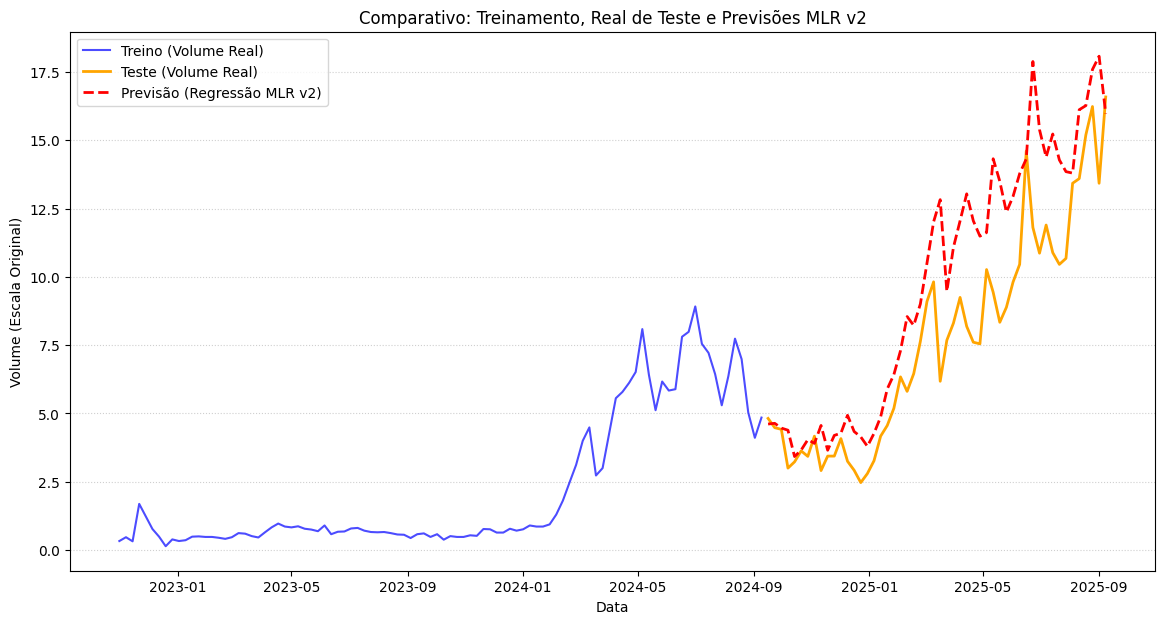

In [151]:
predictions_series = pd.Series(y_pred_orig_v3, index=test_df.index)

plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df['volume'], label='Treino (Volume Real)', color='blue', alpha=0.7)
plt.plot(test_df.index, test_df['volume'], label='Teste (Volume Real)', color='orange', linewidth=2)

# Previsões da Regressão Múltipla
plt.plot(predictions_series.index, predictions_series.values, 
         label='Previsão (Regressão MLR v2)', color='red', linestyle='--', linewidth=2)

plt.title('Comparativo: Treinamento, Real de Teste e Previsões MLR v2')
plt.xlabel('Data')
plt.ylabel('Volume (Escala Original)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

## Análise dos Resíduos

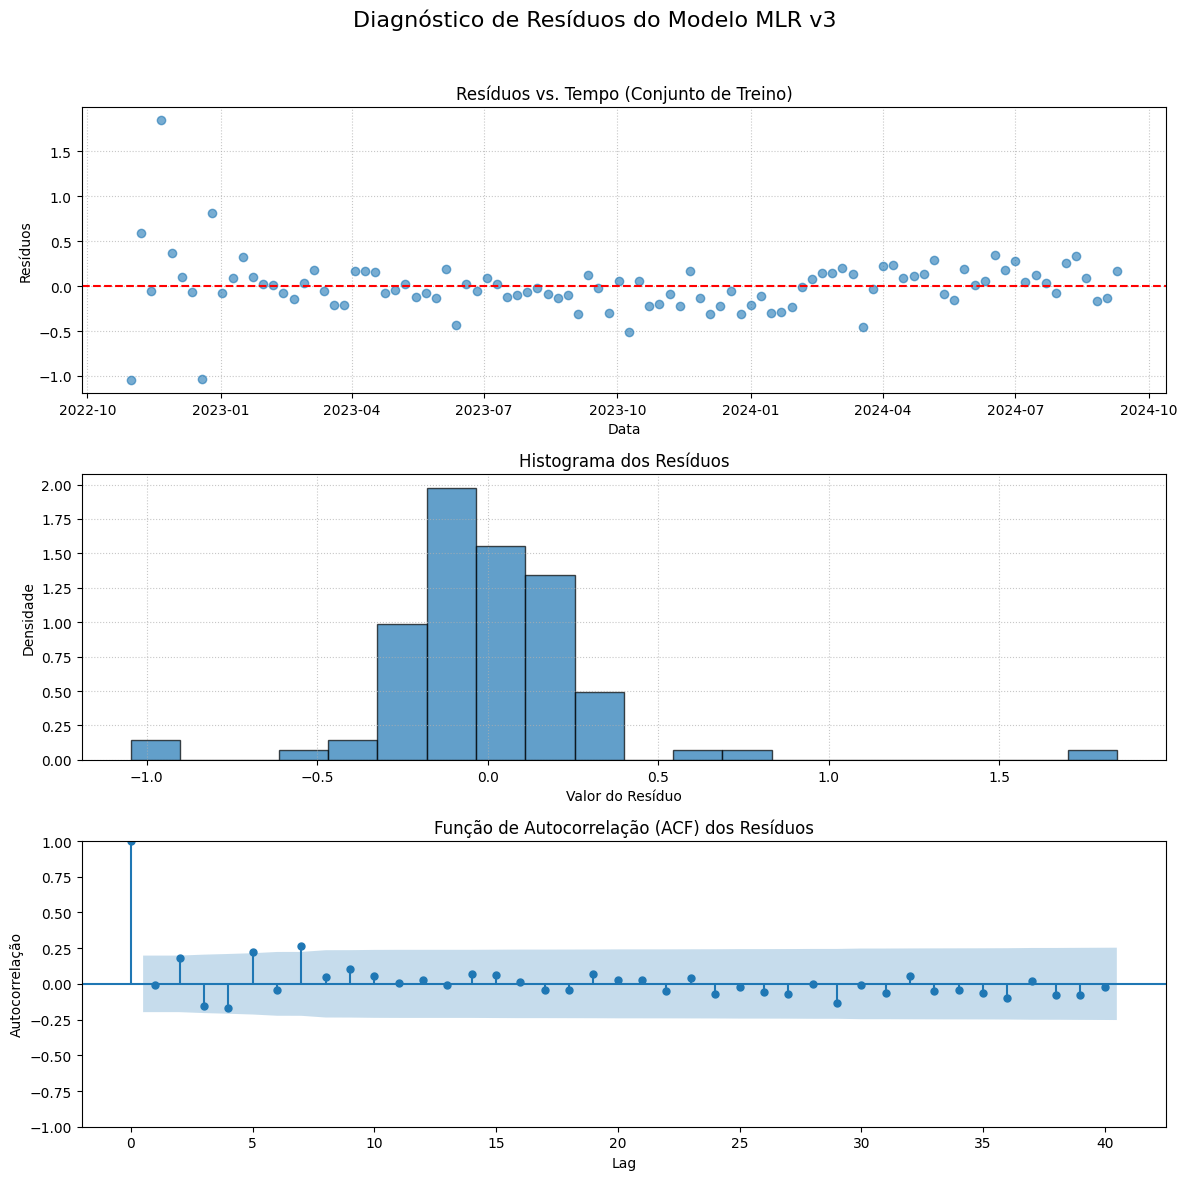


--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---
      lb_stat  lb_pvalue
10  12.260790   0.267982
20  14.495843   0.804493
30  19.421803   0.930732
40  24.990036   0.969512


In [152]:
residuos_v3 = y_train_v3 - model_v3.predict(X_train_v3)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR v3', fontsize=16)

# 1. Gráfico de Resíduos ao Longo do Tempo
axs[0].plot(residuos_v3.index, residuos_v3, marker='o', linestyle='None', alpha=0.6)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True, linestyle=':', alpha=0.7)

# 2. Histograma dos resíduos para verificar a normalidade
axs[1].hist(residuos_v3, bins=20, density=True, edgecolor='k', alpha=0.7)
axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True, linestyle=':', alpha=0.7)

# 3. Função de autocorrelação (ACF) para verificar independência
sm.graphics.tsa.plot_acf(residuos_v3, lags=40, ax=axs[2])
axs[2].set_title('Função de Autocorrelação (ACF) dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste de Ljung-Box para autocorrelação nos resíduos
ljung_box_results_v3 = acorr_ljungbox(residuos_v3, lags=[10, 20, 30, 40], return_df=True)
print("\n--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---")
print(ljung_box_results_v2)

### Análise de Diagnóstico do Modelo MLR v3

O primeiro gráfico mostra dois pontos positivos: **1)** os resíduos estão bem distribuídos em torno da linha zero, sem tendência aparente, indicando que o modelo capturou o comportamento principal da série; e **2)** a variância dos resíduos parece ser constante ao longo do tempo (homocedasticidade).

O segundo gráfico, por sua vez, exibe uma distribuição de resíduos que, apesar de uma leve assimetria à direita, se aproxima de uma **distribuição Normal com média zero**, o que é um resultado bastante positivo e desejável.

No gráfico de ACF, a autocorrelação para **todos os lags** está dentro do intervalo de confiança. Isso é um sinal excelente, indicando que os **resíduos são independentes** e que o modelo conseguiu modelar com sucesso a estrutura de dependência temporal dos dados.

## **Conclusão**

Apesar dos ótimos diagnósticos mostrarem um modelo estatisticamente válido, os valores de **MAE (2.11)**, **RMSE (2.72)** e **MAPE (29.18%)** são ligeiramente superiores aos do modelo v1 inicial. Isso não indica um problema, mas sim um **trade-off clássico**: trocamos uma pequena fração da performance preditiva por um modelo muito mais robusto e confiável.

Desse modo, o modelo v3 representa um excelente meio-termo entre a simplicidade do v1 e o overfitting do v2. Ele serve como um baseline sólido e estatisticamente válido, a partir do qual futuras melhorias (como a experimentação com modelos não-lineares) podem ser exploradas para tentar reduzir ainda mais as métricas de erro.